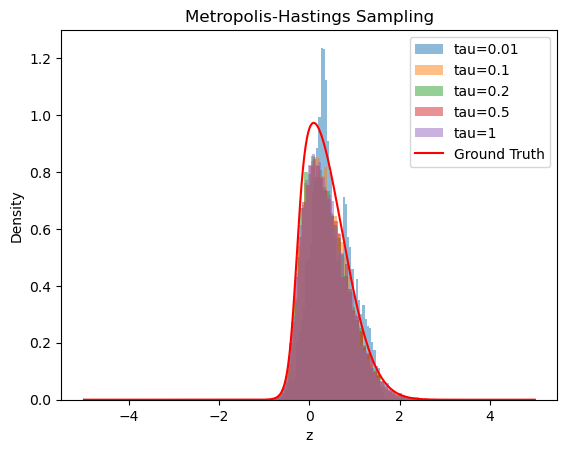

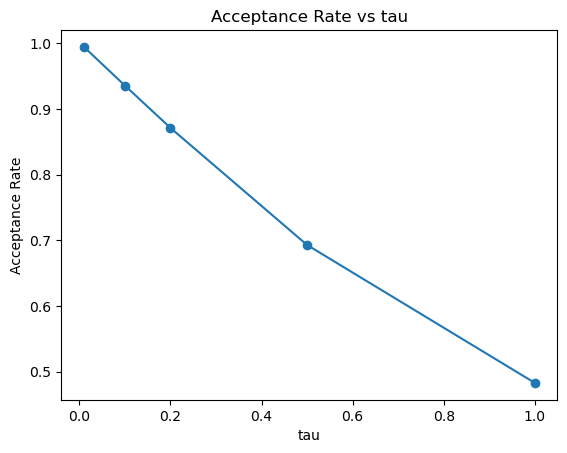

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))
# Define the function p(z)
def p_z(z):
    #return np.exp(-z**2/2)*sigmoid(20*z+4)
    return np.exp(-z**2) * sigmoid(10*z + 3)


# Define the proposal distribution q(z_{n+1} | z_n)
def proposal_distribution(z_current, tau):
    return np.random.normal(z_current, tau)

# Metropolis-Hastings algorithm
def metropolis_hastings(num_samples, tau):
    # Initialize variables
    samples = [0]  # Initial sample
    accepted = 0
    
    for _ in range(num_samples):
        # Generate candidate sample from proposal distribution
        candidate = proposal_distribution(samples[-1], tau)
        
        # Calculate acceptance probability
        acceptance_prob = min(1, p_z(candidate) / p_z(samples[-1]))
        
        # Accept or reject candidate
        if np.random.rand() < acceptance_prob:
            samples.append(candidate)
            accepted += 1
        else:
            samples.append(samples[-1])
    
    # Calculate acceptance rate
    acceptance_rate = accepted / num_samples
    
    return samples[::10], acceptance_rate

taus = [0.01, 0.1, 0.2, 0.5, 1]
num_samples = 150000
final_samples = []
acceptance_rates = []

# Run Metropolis-Hastings for each tau
for tau in taus:
    samples, acceptance_rate = metropolis_hastings(num_samples, tau)
    final_samples.append(samples)
    acceptance_rates.append(acceptance_rate)
    
    # Plot normalized histogram
    plt.hist(samples, bins=50, density=True, alpha=0.5, label=f'tau={tau}')

# Plot ground-truth density curve
z_values = np.linspace(-5, 5, 1000)
plt.plot(z_values, p_z(z_values), 'r-', label='Ground Truth')

plt.legend()
plt.xlabel('z')
plt.ylabel('Density')
plt.title('Metropolis-Hastings Sampling')
plt.show()

# Plot acceptance rate vs tau
plt.plot(taus, acceptance_rates, marker='o')
plt.xlabel('tau')
plt.ylabel('Acceptance Rate')
plt.title('Acceptance Rate vs tau')
plt.show()


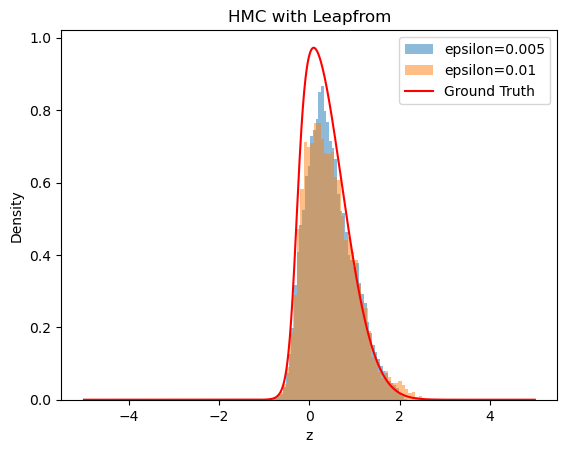

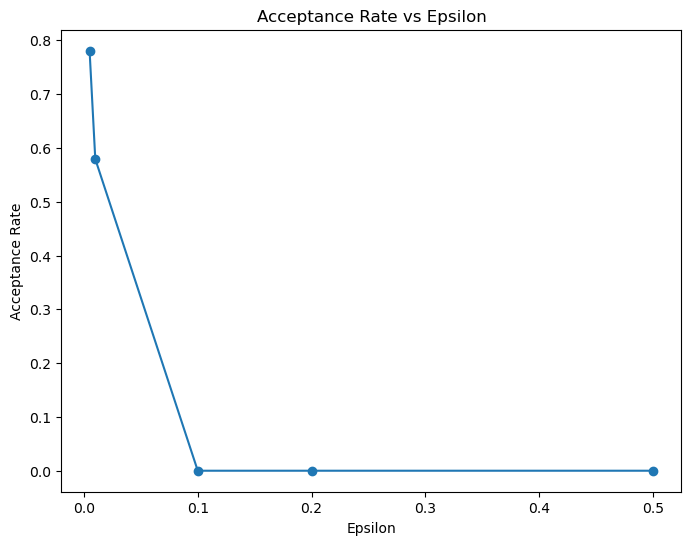

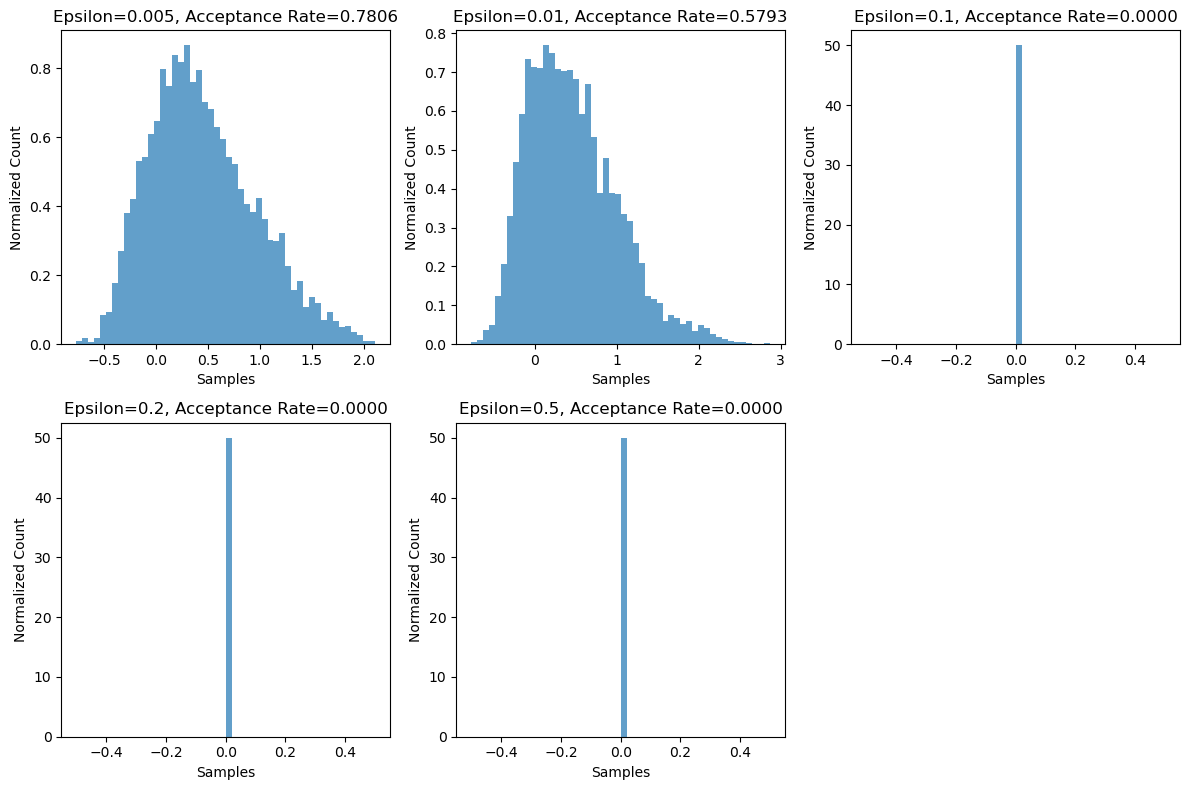

In [9]:


# Leapfrog integrator
def leapfrog(z, p, epsilon, L):
    z_new, p_new = z, p
    for _ in range(L):
        p_new -= 0.5 * epsilon * (-2 * z_new - 10)  # half step for momentum
        z_new += epsilon * p_new                     # full step for position
        p_new -= 0.5 * epsilon * (-2 * z_new - 10)  # half step for momentum
    return z_new, p_new

# Hybrid Monte Carlo sampling
def hmc_sampling(epsilon, L, num_samples):
    # Initialization
    z_samples = []
    z_current = 0
    num_accepted = 0

    for _ in range(num_samples):
        # Sample momentum from a normal distribution
        p_current = np.random.normal(0, 1)

        # Perform Leapfrog dynamics
        z_proposed, p_proposed = leapfrog(z_current, p_current, epsilon, L)

        # Metropolis-Hastings acceptance criterion
        alpha = min(1, p_z(z_proposed) / p_z(z_current) * np.exp(-0.5 * (p_proposed**2 - p_current**2)))

        # Accept/reject proposal
        if np.random.rand() < alpha:
            z_current = z_proposed
            num_accepted += 1

        z_samples.append(z_current)

    acceptance_rate = num_accepted / num_samples
    return np.array(z_samples), acceptance_rate

# Parameters
epsilons = [0.005, 0.01, 0.1, 0.2, 0.5]
L = 10
burn_in_iterations = 100000
sampling_iterations = 50000
thinning_factor = 10
num_final_samples = sampling_iterations // thinning_factor

# Run HMC for different epsilon values
acceptance_rates = []
final_samples = []

for epsilon in epsilons:
    # Burn-in phase
    hmc_sampling(epsilon, L, burn_in_iterations)
    
    # Sampling phase
    samples, acceptance_rate = hmc_sampling(epsilon, L, sampling_iterations)
    final_samples.append(samples[::thinning_factor])  # Thinning to get final samples
    acceptance_rates.append(acceptance_rate)
    
    # Plot normalized histogram
    if acceptance_rate > 1e-4:
        plt.hist(samples, bins=50, density=True, alpha=0.5, label=f'epsilon={epsilon}')

# Plot ground-truth density curve
z_values = np.linspace(-5, 5, 1000)
plt.plot(z_values, p_z(z_values), 'r-', label='Ground Truth')

# Plot histograms on top of each other (ones that have above 0 acceptance rates)
plt.legend()
plt.xlabel('z')
plt.ylabel('Density')
plt.title('HMC with Leapfrom')
plt.show()


# Plot epsilon vs acceptance rate
plt.figure(figsize=(8, 6))
plt.plot(epsilons, acceptance_rates, marker='o')
plt.title('Acceptance Rate vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Acceptance Rate')
plt.show()

# Plot histograms of final samples for each epsilon
plt.figure(figsize=(12, 8))
for i, epsilon in enumerate(epsilons):
    plt.subplot(2, 3, i+1)
    plt.hist(final_samples[i], bins=50, density=True, alpha=0.7)
    plt.title(f'Epsilon={epsilon}, Acceptance Rate={acceptance_rates[i]:.4f}')
    plt.xlabel('Samples')
    plt.ylabel('Normalized Count')
plt.tight_layout()
plt.show()


### Question 2

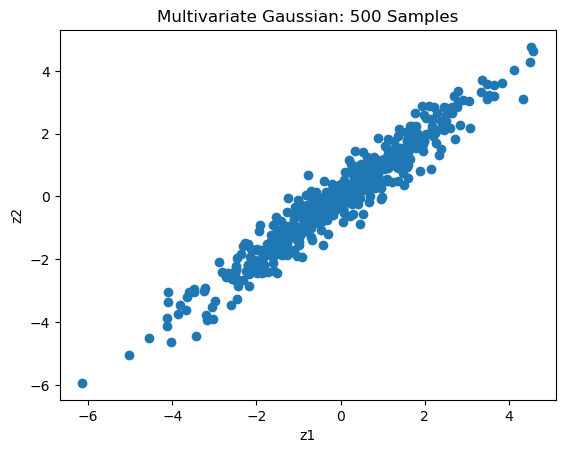

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define mean and covariance matrix
mean = np.array([0, 0])
covariance = np.array([[3, 2.9], [2.9, 3]])

# Draw 500 samples from the distribution
samples = np.random.multivariate_normal(mean, covariance, size=500)

# Plot scatter plot
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Multivariate Gaussian: 500 Samples')
plt.show()

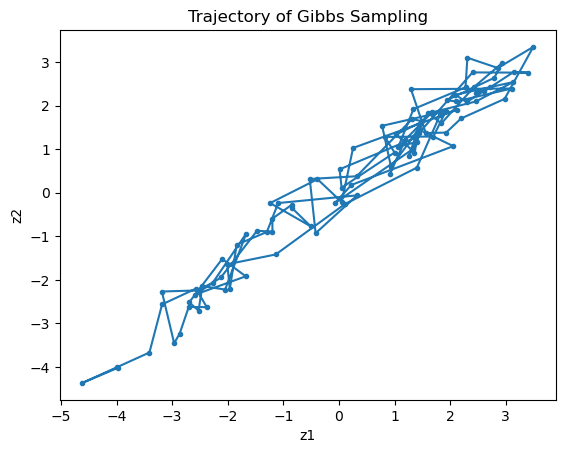

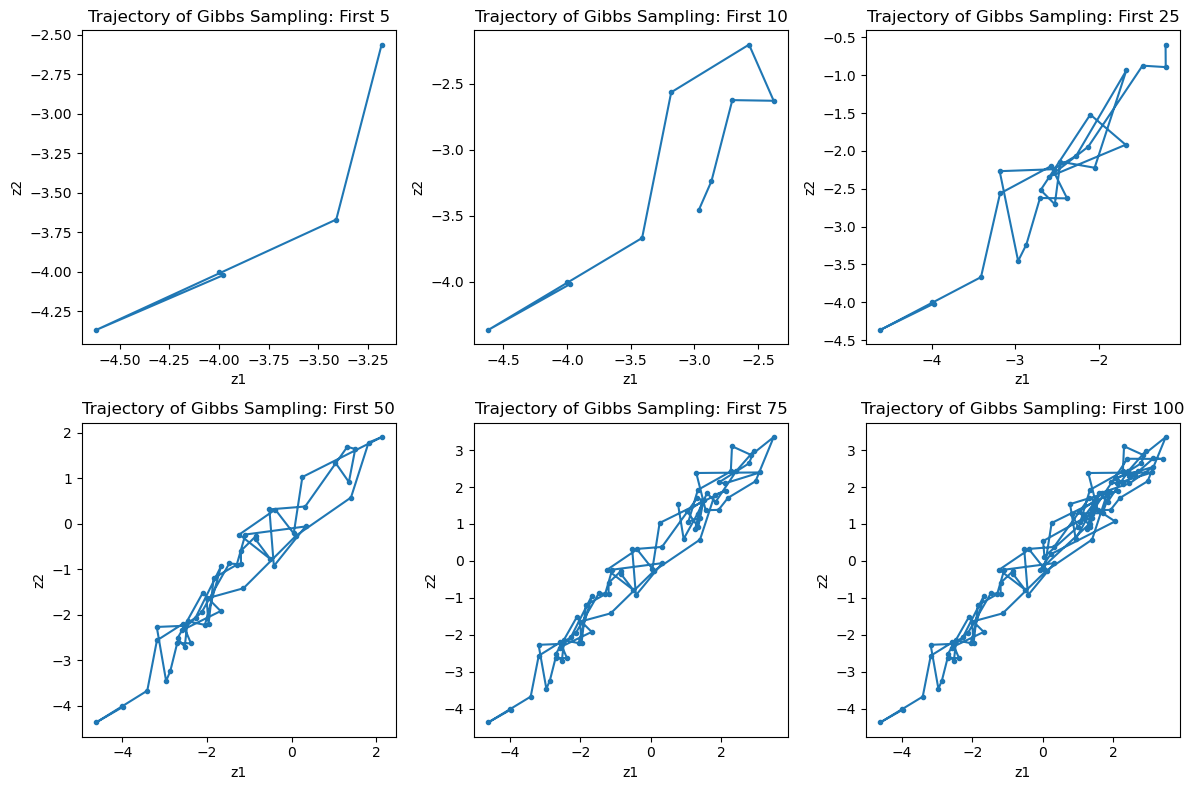

In [15]:
# Gibbs sampling function
def gibbs_sampling(num_iterations, initial_sample):
    samples = [initial_sample]
    for _ in range(num_iterations):
        # Sample z1 given z2
        mean_z1_given_z2 = covariance[0, 1] / covariance[1, 1] * (samples[-1][1] - mean[1])
        z1 = np.random.normal(mean_z1_given_z2 + mean[0], np.sqrt(covariance[0, 0] - (covariance[0, 1] ** 2 / covariance[1, 1])))
        
        # Sample z2 given z1
        mean_z2_given_z1 = covariance[1, 0] / covariance[0, 0] * (z1 - mean[0])
        z2 = np.random.normal(mean_z2_given_z1 + mean[1], np.sqrt(covariance[1, 1] - (covariance[1, 0] ** 2 / covariance[0, 0])))
        
        samples.append([z1, z2])
    return np.array(samples)

# Run Gibbs sampling for 100 iterations
initial_sample = np.array([-4, -4])
gibbs_samples = gibbs_sampling(100, initial_sample)

# Plot trajectory of samples
plt.plot(gibbs_samples[:, 0], gibbs_samples[:, 1], marker='.')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Trajectory of Gibbs Sampling')
plt.show()

# Plot Gibbs in steps
plt.figure(figsize=(12, 8))
for i, n in enumerate([5, 10, 25, 50, 75, 100]):
    plt.subplot(2, 3, i+1)
    plt.plot(gibbs_samples[:n, 0], gibbs_samples[:n, 1], marker='.')
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title(f'Trajectory of Gibbs Sampling: First {n}')
plt.tight_layout()
plt.show()
